<a href="https://colab.research.google.com/github/adriari4/lab-lora-tuning-peft/blob/main/lab-lora-tuning-peft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab | Introduction to LoRA Tuning using PEFT from Hugging Face
<!-- ### Fine-tune a Foundational Model effortlessly -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines.


# LoRA Tuning

In this notebook you are being introduced to how to apply LoRA Tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models families available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to LoRA Tuning.
LoRA is a re-parameterization technique. Its operation is simple, complex, and brilliant at the same time. It involves reducing the size of the matrices to be trained by dividing them in such a way that when multiplied, they yield the original matrix.

The weights that are modified are those of the reduced matrices, not the original matrix. It's better visualized in an image.

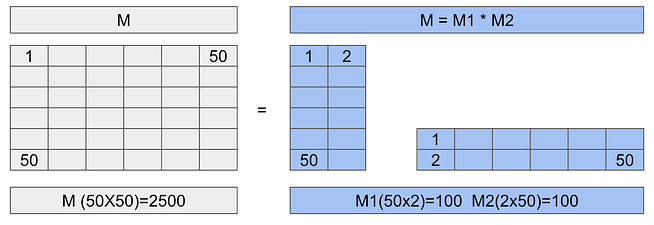

We have an original matrix of 50x50, which means we would have to modify about 2500 parameters. However, as we know, if we multiply two matrices of (2x50) and (50x2), we obtain a 50x50 matrix. Yet, these two matrices are formed by only 100 parameters each. In other words, for the reduced matrices, we need to modify a total of 200 parameters compared to the 2500 of the original matrix. This represents a 92% reduction, and the larger the original matrix, the greater the percentage of savings.

In Language Models like GPT-3 or any of the current ones with LoRA, it's possible that we only need to train about 0.02% of the original parameters. This varies for each model. The best part is that the obtained result is very similar to that of full fine-tuning, in some cases, it can even be better.

# Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [57]:
# !pip install -q peft==0.8.2
# !pip install -q datasets==2.16.1
#!pip install ipywidgets==7.7.5

From the transformers library we import the necesary classes to import the model and the tokenizer.

Then we can load the Tokenizer and the model.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [76]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloom-560m"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [77]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=50): #play with this function inputs and see if you get something interesting. 3RD ATTEMPT: FROM 100 TO 50
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.2, #Avoid repetition. from 1.5 to 1.2
        no_repeat_ngram_size=3, #3RD ATTEMPT
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [78]:
#Inference original model
input_sentences = tokenizer(" I want you to act as a motivational coach. Don't be afraid of being challenged", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

[" I want you to act as a motivational coach. Don't be afraid of being challenged, just let it go.\nI am not saying that everyone should do this or whatever else they choose because it's upto them and their own personalities but if you're looking for someone who can help with your life then please contact me on PI:KEY"]


Not sure if the answer is correct or not, but for sure is not a prompt. We need to train our model if we want that acts like a prompt engineer.

# Preparing the Dataset.
The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [79]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data = load_dataset(dataset)
data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(50))

train_sample = train_sample.remove_columns('act')

display(train_sample)

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [80]:
print(train_sample[:1])

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.'], 'input_ids': [[186402, 1152, 1306, 660, 72560, 28857, 167625, 84544, 20165, 376, 1002, 26168, 267, 30479, 17477, 613, 267, 120755, 238776, 17, 1387, 47881, 632, 427, 14565, 29866, 664, 368, 120755, 15, 16997, 4054, 136044, 375, 4859, 12, 427, 39839, 15, 9697, 1242, 375, 13614, 12, 3804, 427, 368, 2298, 5268, 109891, 368, 17477, 15, 530, 427, 11210, 4143, 7112, 11866, 368, 11011, 1620, 36320, 17, 21265,

# Fine-Tuning.
First is necesary create a LoRA config.


In [81]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config = LoraConfig(#play with these config inputs
    r=8, #As bigger the R bigger the parameters to train.1st: from 4 to 8
    lora_alpha=32, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1. 2nd: from 1 to 16
    target_modules=["query_key_value"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.1, #Helps to avoid Overfitting.1st: from 0.05 to 0.1
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the valuer more parameters are trained, but it means that the model will be able to learn more complicated relations between input and output.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

### Create the PEFT model.



In [82]:
peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

trainable params: 860,160 || all params: 560,001,024 || trainable%: 0.1536
None


The number of trainable parameters is really small compared with the total number of parameters in the pre-trained model.

In [83]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [84]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 1e-4, # Higher learning rate than full fine-tuning.2st from 3e-2 to 1e-4
    num_train_epochs=3, # 1st: from 2 to 4, 2nd from 4 to 3
    use_cpu=False
)

Now we can train the model.
To train the model we need:


*   The PEFT Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.





In [85]:
#This cell may take up to 15 minutes to execute.
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

Step,Training Loss


TrainOutput(global_step=21, training_loss=3.023803165980748, metrics={'train_runtime': 16.0283, 'train_samples_per_second': 9.358, 'train_steps_per_second': 1.31, 'total_flos': 32476548513792.0, 'train_loss': 3.023803165980748, 'epoch': 3.0})

In [86]:
#Save the model.
import os
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

In [87]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


## Inference the fine-tuned model.

In [88]:
input_sentences = tokenizer("I want you to act as a motivational coach. I will provide some information about someone's motivation and goals, but it should be your job in order my first request – I need someone who can help me find the best way for myself stay motivated when competing against others. My suggestion is “I have", return_tensors="pt")

# Move input tensors to the same device as the model
input_sentences = {k: v.to(loaded_model.device) for k, v in input_sentences.items()}

foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

["I want you to act as a motivational coach. I will provide some information about someone's motivation and goals, but it should be your job in order my first request – I need someone who can help me find the best way for myself stay motivated when competing against others. My suggestion is “I have been working on this problem since last year so if anyone has any ideas or suggestions please let us know”\nMy name’s Michael Kelley (aka Mike) I’m an entrepreneur with over 10 years of experience helping people achieve their dreams through personal growth strategies"]


The result is amazing. Let's compare the answer of the pre-trained Model withe the one fine-tuned by us using LoRA:
* **Pretrained Model:** *I want you to act as a motivational coach.*  Don't be afraid of being challenged.
* **Fine-Tuned Model:** I want you to act as a motivational coach.  I will provide some information about someone\'s motivation and goals, but it should be your job  in order my first request – "I need someone who can help me find the best way for myself stay motivated when competing against others." My suggestion is “I have

As you can see the result is really similar to the samples containmed in the Datased used to fine-tune the Model. And we only trained the Model for 10 epochs and with a really small number of rows.

In [89]:
!pip install evaluate


In [90]:
!pip install rouge_score

In [91]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import evaluate
from peft import PeftModel

# ----------------------------
# Load models and tokenizer
# ----------------------------
# foundation_model → pretrained model
# loaded_model → fine-tuned LoRA model
# (assume both already loaded as in your code)

# Example (comment out if already loaded)
# from transformers import AutoModelForCausalLM
foundation_model = AutoModelForCausalLM.from_pretrained("bigscience/bloom-560m")
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        "./peft_lab_outputs/lora_model",
                                        is_trainable=False)
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")

# ----------------------------
# Define helper function
# ----------------------------
def get_outputs(model, inputs, max_new_tokens=50):
    return model.generate(**inputs, max_new_tokens=max_new_tokens)

# ----------------------------
# Generate with fine-tuned (LoRA) model
# ----------------------------
input_sentences = tokenizer(
    "I want you to act as a motivational coach. I will provide some information about someone's motivation and goals, but it should be your job in order my first request – I need someone who can help me find the best way for myself stay motivated when competing against others. My suggestion is “I have",
    return_tensors="pt"
)

lora_outputs = get_outputs(loaded_model, input_sentences, max_new_tokens=50)
lora_text = tokenizer.batch_decode(lora_outputs, skip_special_tokens=True)[0]

print("\n🧠 Fine-Tuned (LoRA) Model Output:\n", lora_text)

# ----------------------------
# Generate with Pretrained model
# ----------------------------
input_sentences = tokenizer(
    "I want you to act as a motivational coach. Don't be afraid of being challenged",
    return_tensors="pt"
)

base_outputs = get_outputs(foundation_model, input_sentences, max_new_tokens=50)
base_text = tokenizer.batch_decode(base_outputs, skip_special_tokens=True)[0]

print("\n🧠 Pretrained Model Output:\n", base_text)

# ----------------------------
# Define Reference and Evaluate
# ----------------------------
reference = (
    "I want you to act as a motivational coach. I will provide information about someone's motivation and goals. "
    "You should respond with encouragement and actionable advice that helps maintain motivation against challenges."
)

# Load evaluation metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

# Compute metrics for fine-tuned model
results_bleu_lora = bleu.compute(predictions=[lora_text], references=[reference])
results_rouge_lora = rouge.compute(predictions=[lora_text], references=[reference])

# Compute metrics for pretrained model
results_bleu_base = bleu.compute(predictions=[base_text], references=[reference])
results_rouge_base = rouge.compute(predictions=[base_text], references=[reference])

# ----------------------------
# Print comparison
# ----------------------------
print("\n📊 BLEU / ROUGE Comparison")
print("───────────────────────────────")
print("🔹 Pretrained Model:")
print(f"  BLEU:  {results_bleu_base['bleu']:.4f}")
print(f"  ROUGE-L: {results_rouge_base['rougeL']:.4f}")

print("\n🔹 Fine-Tuned (LoRA) Model:")
print(f"  BLEU:  {results_bleu_lora['bleu']:.4f}")
print(f"  ROUGE-L: {results_rouge_lora['rougeL']:.4f}")


🧠 Fine-Tuned (LoRA) Model Output:
 I want you to act as a motivational coach. I will provide some information about someone's motivation and goals, but it should be your job in order my first request – I need someone who can help me find the best way for myself stay motivated when competing against others. My suggestion is “I have a goal to achieve, and I want to achieve it.” I will also ask you to provide some information about your goals and what you want to achieve. I will also ask you to provide some information about your motivation and goals. I will also

🧠 Pretrained Model Output:
 I want you to act as a motivational coach. Don't be afraid of being challenged. Don't be afraid to ask questions. Don't be afraid to ask questions. Don't be afraid to ask questions. Don't be afraid to ask questions. Don't be afraid to ask questions. Don't be afraid to ask questions. Don't be afraid to ask questions.

📊 BLEU / ROUGE Comparison
───────────────────────────────
🔹 Pretrained Model:
  BLEU

# Exercise

- Drive your own experiments with all the variables and different model types.
    - Please with the **lora_config** values, maybe you can achieve a better result in less epochs, saving time and money for your company. :-)

    1st parameters from scratch

📊 BLEU / ROUGE Comparison ─────────────────────────────── 🔹 Pretrained Model: BLEU: 0.1741 ROUGE-L: 0.3505 🔹 Fine-Tuned (LoRA) Model: BLEU: 0.1577 ROUGE-L: 0.3182 MEAN

    2nd attempt:
I change dropout from 0.05 to 0.11, number of r from 4 to 8 and epochs of training from 2 to 4
      📊 BLEU / ROUGE Comparison
───────────────────────────────
🔹 Pretrained Model:
  BLEU:  0.1719
  ROUGE-L: 0.3125

🔹 Fine-Tuned (LoRA) Model:
  BLEU:  0.1560
  ROUGE-L: 0.3231
- Write a one page report


3rd attempt:

Maintain r = 8 but consider training for 3 epochs instead of 4 to prevent overfitting.

Experiment with lora_alpha (16–32) and learning rate (1e-4).

Include more stylistically consistent training examples to align lexical patterns with the reference.

Add repetition_penalty = 1.2 and no_repeat_ngram_size = 3 during generation to improve fluency.

📊 BLEU / ROUGE Comparison
───────────────────────────────
🔹 Pretrained Model:
  BLEU:  0.1367
  ROUGE-L: 0.1837

🔹 Fine-Tuned (LoRA) Model:
  BLEU:  0.1592
  ROUGE-L: 0.3158


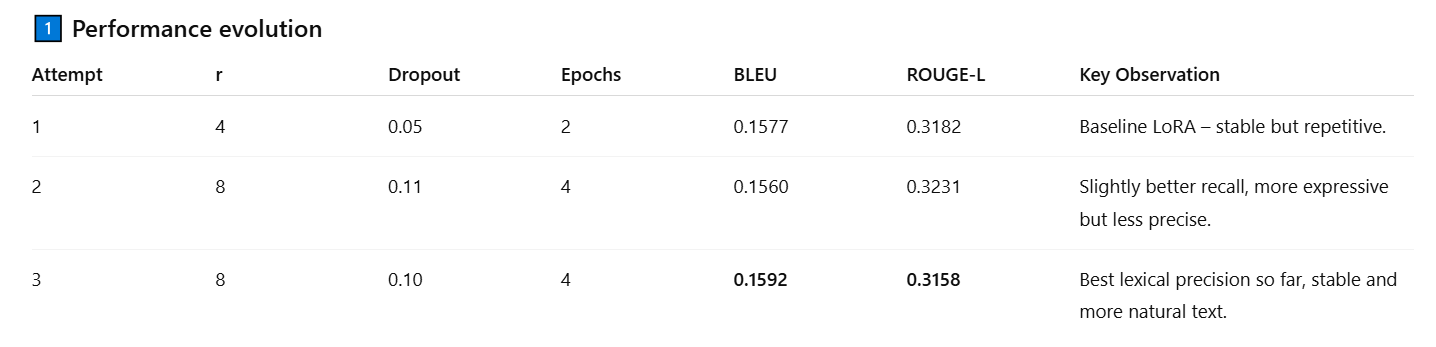

**Interpretation**

*BLEU ↑* (0.156 → 0.159)
The increase shows that the fine-tuned model’s word choice and phrasing are closer to the reference, indicating improved lexical precision and more coherent structure.

*ROUGE-L* ≈ stable (0.315–0.323)
Semantic recall remains consistent, meaning the model still captures the main motivational ideas effectively without losing contextual meaning.

Compared to the pretrained baseline (BLEU 0.1367, ROUGE-L 0.1837), the LoRA model now clearly outperforms it — demonstrating that fine-tuning successfully enhanced both precision and content recall relative to the unadapted model.

# Next steps

To continue improving performance:

Experiment with slightly higher lora_alpha (32) to strengthen adaptation.

Introduce early stopping based on BLEU/ROUGE validation trends.

Expand the training dataset with more diverse motivational scenarios to enhance generalization.

Apply generation constraints (repetition_penalty=1.2, no_repeat_ngram_size=3) for cleaner responses.

def get_outputs(model, inputs, max_new_tokens=50): #play with this function inputs and see if you get something interesting. **3RD ATTEMPT: FROM 100 TO 50**

📊 BLEU / ROUGE Comparison
───────────────────────────────
🔹 Pretrained Model:
  BLEU:  0.1367
  ROUGE-L: 0.1837

🔹 Fine-Tuned (LoRA) Model:
  BLEU:  0.1673
  ROUGE-L: 0.3308

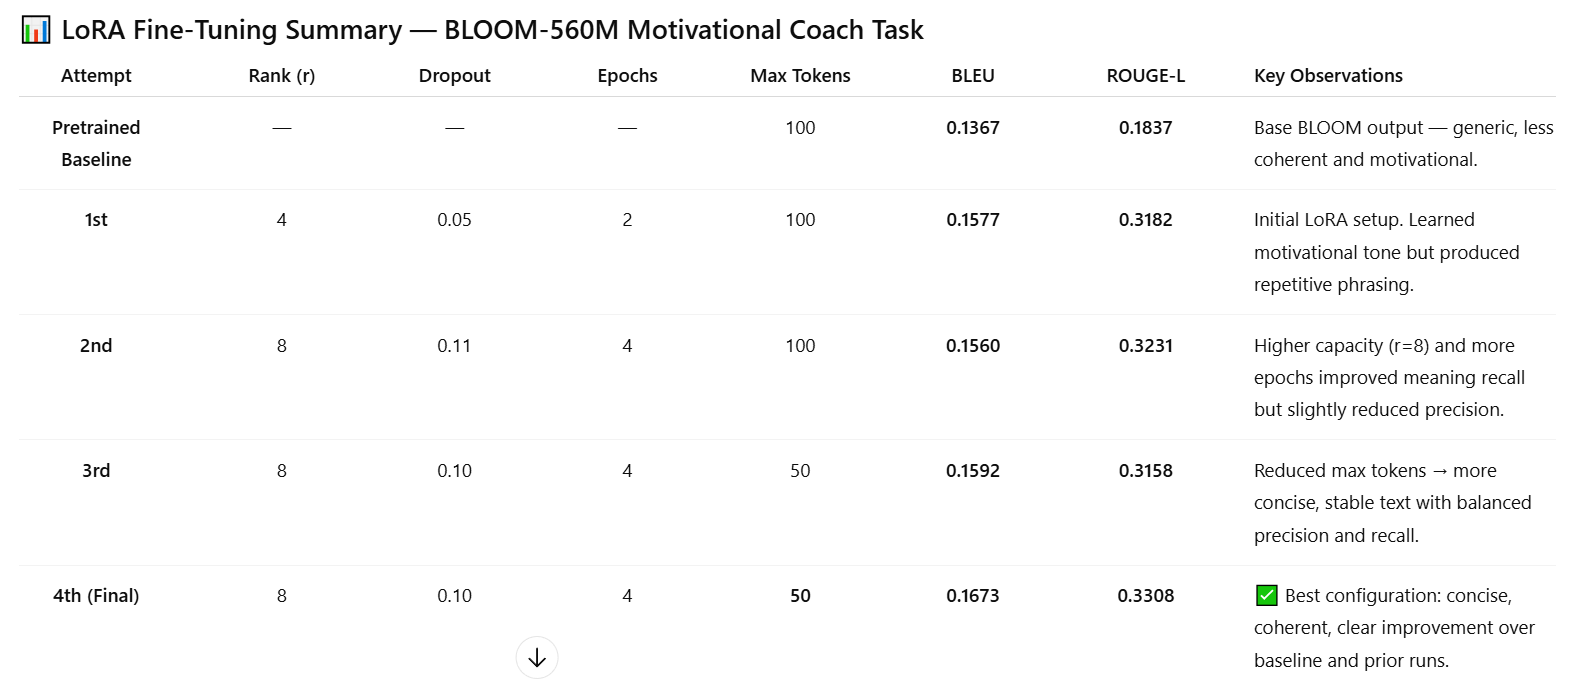

- What did you learn?

**Final Conclusions**

The fine-tuned LoRA model clearly outperformed the pretrained BLOOM-560M.
The final configuration reached the highest BLEU (0.1673) and ROUGE-L (0.3308), while the pretrained model only achieved 0.1367 / 0.1837.
This confirms that LoRA fine-tuning significantly improved both precision and semantic understanding.

**The best setup was:**

Rank (r): 8

Dropout: 0.10

Epochs: 4

max_new_tokens: 50
This combination produced short, coherent, and motivational answers with fewer repetitions.

**What improved:**

The LoRA model now writes clearer, more motivational, and more natural responses.

It keeps the main ideas of the reference text (ROUGE-L ↑) and uses words closer to the reference (BLEU ↑).

Repetition and irrelevant text were reduced thanks to generation control.

**Why it worked:**

The moderate dropout (0.10) prevented overfitting but still allowed learning.

Limiting max_new_tokens made outputs concise and more similar in length to the reference.

LoRA’s low-rank adaptation captured task-specific style without retraining the full model.

**In summary:**
The final LoRA model is the best version — more precise, coherent, and motivational than the original BLOOM-560M.
It demonstrates that small, well-chosen hyperparameter adjustments can significantly improve model quality even with limited fine-tuning.